In [6]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Iterable, Tuple
from typing_extensions import Self
%matplotlib inline

In [7]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [27]:
class Value:

    def __init__(self, data: float, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Self) -> Self:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad+= 1.0 * out.grad
        out._backward = _backward
             
        return out
    
    def __mul__(self, other: Self) -> Self:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other: Self) -> Self:
        return self * other
    
    def __truediv__(self, other: Self) -> Self:
        return self * other ** -1
    
    def __pow__(self, other: Self) -> Self:
        assert isinstance(other, (int, float)), "Exponent must be a scalar"
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other: Self) -> Self:
        return self + (-other)
        
    def __neg__(self) -> Self:
        return self * -1
    
    def __radd__(self, other: Self) -> Self:
        return self + other
    
    def tanh(self) -> Self:
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self) -> Self:
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    

    def backward(self) -> None:

        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [9]:
a = Value(2.0)
b = Value(4.0)
a / b
a - b

Value(data=-2.0)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


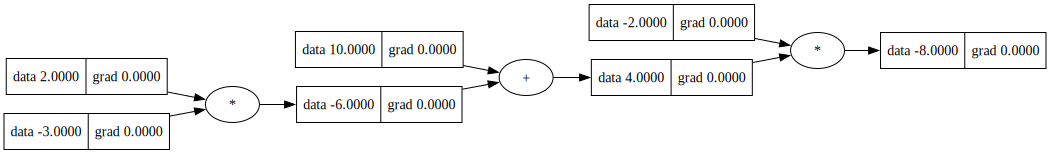

In [11]:
draw_dot(L)

### Neurons

In [12]:
# input values
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# output
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'\

# o = n.tanh(); o.label = 'o'
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e + 1); o.label = 'o'
o.backward()



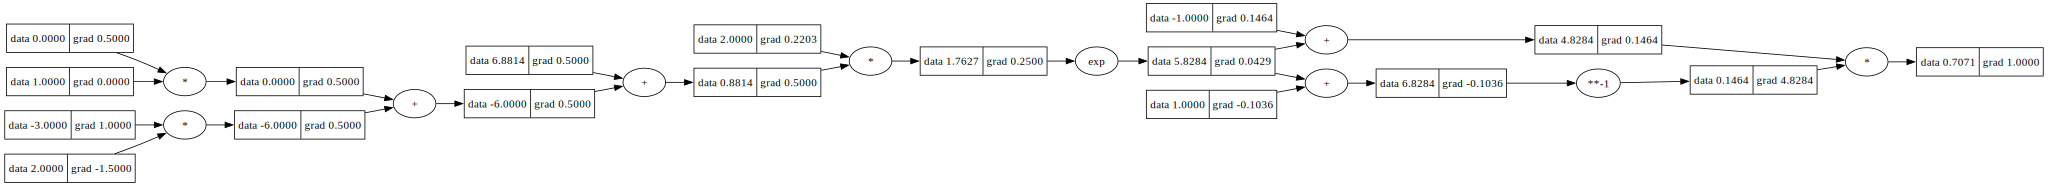

In [13]:
draw_dot(o)

In [14]:
o.backward()

### Pytorch version

In [15]:
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2.grad', x2.grad.item())
print('x1.grad', x1.grad.item())
print('w1.grad', w1.grad.item())
print('w2.grad', w2.grad.item())

0.7071066904050358
x2.grad 0.5000001283844369
x1.grad -1.5000003851533106
w1.grad 1.0000002567688737
w2.grad 0.0


### Neural Nets

In [73]:
class Neuron:
    def __init__(self, n_inputs) -> None:
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]

class Layer:
    def __init__(self, n_inputs, n_outputs) -> None:
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, n_inputs, n_outputs):
        sizes = [n_inputs] + n_outputs
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [113]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8196943529672258)

In [76]:
len(n.parameters())

41

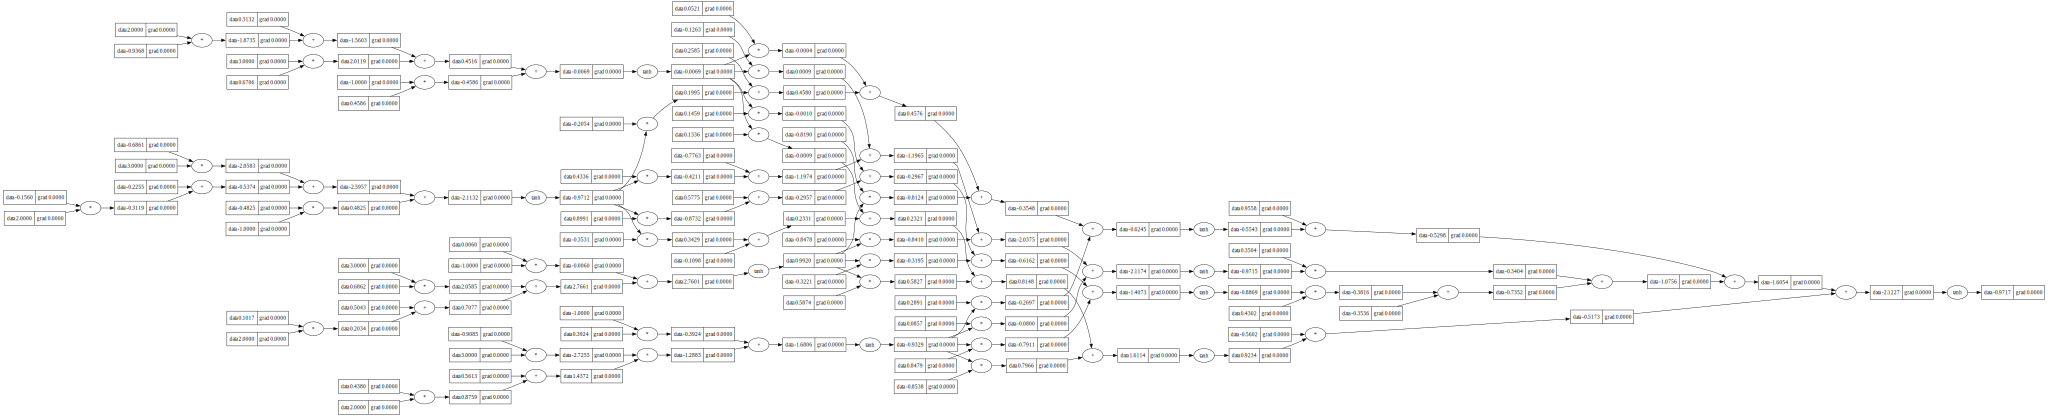

In [58]:
draw_dot(n(x))

### Backprop example

In [114]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # data, 4 samples, 3 features

ys = [1.0, -1.0, -1.0, 1.0] # desired targets




In [105]:
# mean squared error loss
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) **2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.737477406590759)

In [120]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) **2 for ygt, yout in zip(ys, ypred)])
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data -= 0.05 * p.grad

    print(k, loss.data)


0 0.007687471725736425
1 0.007605897239552681
2 0.007525982799668384
3 0.007447678868785531
4 0.007370937848079698
5 0.007295713983688326
6 0.007221963278545666
7 0.007149643409211521
8 0.00707871364736805
9 0.007009134785681706
10 0.006940869067750886
11 0.006873880121879202
12 0.006808132898433231
13 0.00674359361056121
14 0.006680229678064335
15 0.006618009674226883
16 0.006556903275426023
17 0.00649688121335245
18 0.006437915229686595
19 0.006379978033084113


In [112]:
ypred

[Value(data=0.9998546033280833),
 Value(data=-0.9999996912293556),
 Value(data=-0.9999999715431853),
 Value(data=0.9998681317055704)]

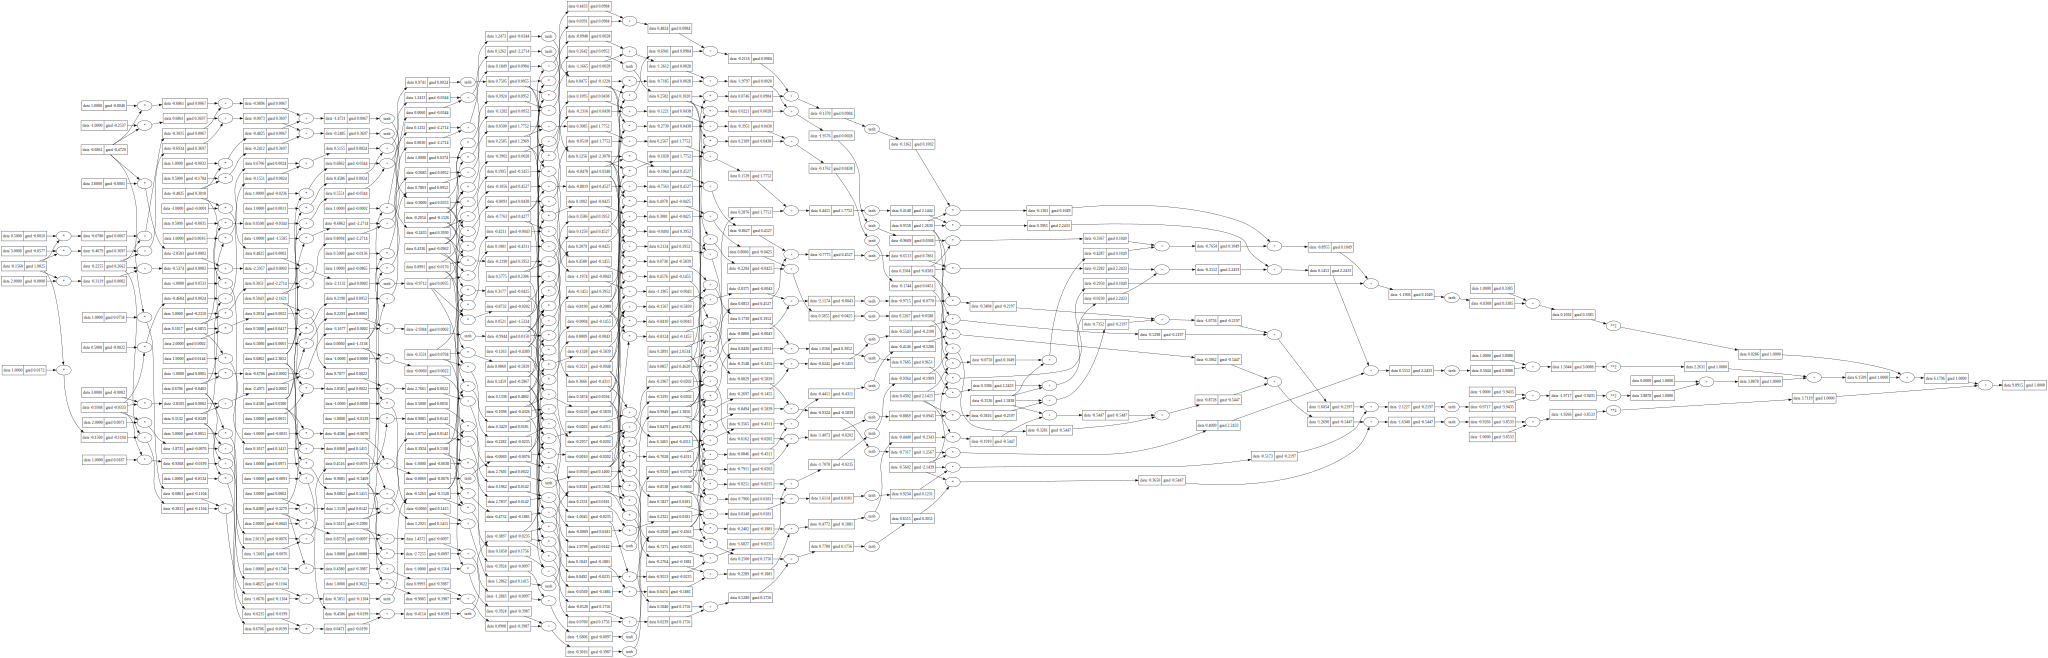

In [71]:
draw_dot(loss)